https://www.sciencedirect.com/science/article/pii/S2211812814005318

In [31]:
# import dependencies
%matplotlib inline
from keras.models import Sequential
from keras.activations import *
from keras.layers import *
from keras.losses import *
from keras.optimizers import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import talos as ta
import warnings
warnings.filterwarnings("ignore")

# suppres NumPy arrays scientific notation and round decimals to three places
np.set_printoptions(suppress=True)
np.printoptions(precision=3, suppress=True)

print('Dependency Version:\n')
print('Keras', keras.__version__)
print('Numpy', np.__version__)
print('Pandas', pd.__version__)
print('Seaborn', seaborn.__version__)
print('Sklearn', sklearn.__version__)
print('Talos', ta.__version__)

In [32]:
# import training data
data = pd.read_csv('data.txt', delim_whitespace=True, encoding='ISO-8859-1')
data.drop(columns=['Sr._No.'], inplace=True)

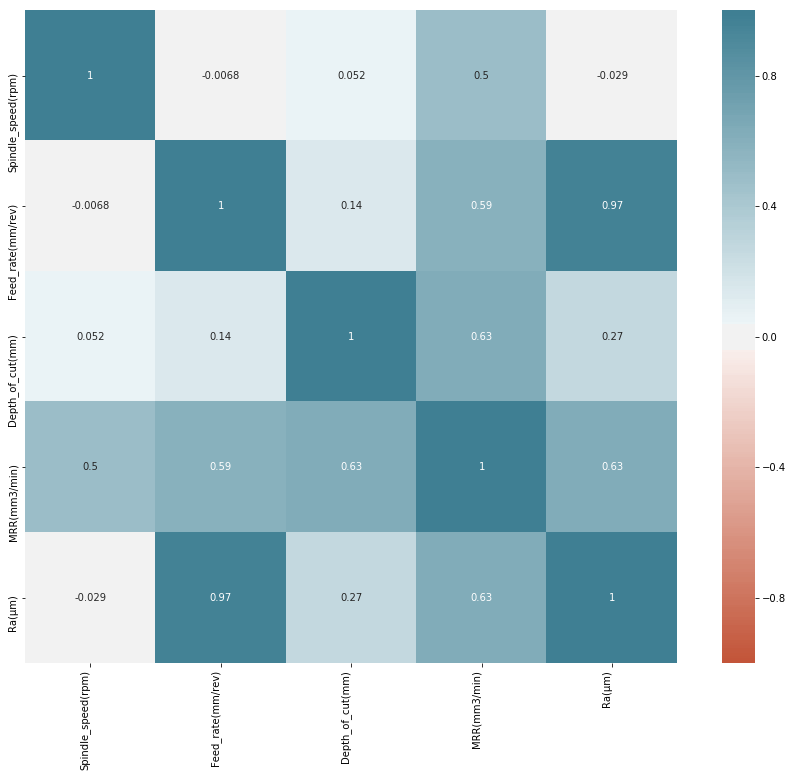

In [33]:
# a look at the overall correlation between training and testing data
heat_data = data
plt.figure(figsize=(16, 12))
corr = heat_data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);
plt.savefig('heatmap')

In [34]:
# change the dataframe into a NumPy array
np_data = data.values

In [35]:
# Transforms features by scaling each feature to a given range, -1 and 1 in this case
MinMax_scaler = MinMaxScaler(feature_range=(-1, 1))
np_data_MinMax = MinMax_scaler.fit_transform(np_data)

In [36]:
# Standardize features by removing the mean and scaling to unit variance
Standard_scaler = StandardScaler()
np_data_Standard = Standard_scaler.fit_transform(np_data)

In [37]:
# split the scaled data into training, testing, and validation sets
train_features_MinMax = np_data_MinMax[0:27 , 3:5]
test_features_MinMax = np_data_MinMax[28:32, 3:5]
validation_features_MinMax = np_data_MinMax[27, 3:5]
train_labels_MinMax = np_data_MinMax[0:27, 0:3]
test_labels_MinMax = np_data_MinMax[28:32, 0:3]
validation_labels_MinMax = np_data_MinMax[27, 0:3]

# reshape the validation data because it's only one row
validation_features_MinMax = validation_features_MinMax.reshape(1, -1)
validation_labels_MinMax = validation_labels_MinMax.reshape(1, -1)

In [38]:
# split the scaled data into training, testing, and validation sets
train_features_Standard = np_data_Standard[0:27 , 3:5]
test_features_Standard = np_data_Standard[28:32, 3:5]
validation_features_Standard = np_data_Standard[27, 3:5]
train_labels_Standard = np_data_Standard[0:27, 0:3]
test_labels_Standard = np_data_Standard[28:32, 0:3]
validation_labels_Standard = np_data_Standard[27, 0:3]

# reshape the validation data because it's only one row
validation_features_Standard = validation_features_Standard.reshape(1, -1)
validation_labels_Standard = validation_labels_Standard.reshape(1, -1)

In [39]:
# combining original the testing group to compare against rescaled groups below
np_test_data = np.concatenate([np_data[28:32, 0:3], np_data[28:32, 3:5]], axis=1)
np_test_data

array([[1100.  ,    0.05,    0.69, 2020.44,    0.29],
       [1095.  ,    0.15,    1.2 , 6054.12,    1.87],
       [1097.  ,    0.13,    1.14, 5329.21,    1.54],
       [1094.  ,    0.12,    1.15, 5197.29,    1.45]])

In [40]:
# combine the MinMax testing group and rescale
test_data_MinMax = np.concatenate([test_labels_MinMax, test_features_MinMax], axis=1)
MinMax_scaler.inverse_transform(test_data_MinMax)

array([[1100.  ,    0.05,    0.69, 2020.44,    0.29],
       [1095.  ,    0.15,    1.2 , 6054.12,    1.87],
       [1097.  ,    0.13,    1.14, 5329.21,    1.54],
       [1094.  ,    0.12,    1.15, 5197.29,    1.45]])

In [41]:
# combine the Standard testing group and rescale
test_data_Standard = np.concatenate([test_labels_Standard, test_features_Standard], axis=1)
Standard_scaler.inverse_transform(test_data_Standard)

array([[1100.  ,    0.05,    0.69, 2020.44,    0.29],
       [1095.  ,    0.15,    1.2 , 6054.12,    1.87],
       [1097.  ,    0.13,    1.14, 5329.21,    1.54],
       [1094.  ,    0.12,    1.15, 5197.29,    1.45]])

In [42]:
# parameters to try during Talos optimization
p = {
    'first_neuron': [8, 12, 24],
    'second_neuron': [36, 48, 62],
    'third_neuron': [36, 48, 62],
    'fourth_neuron': [8, 12, 24],
    'batch_size': [10, 20, 30],
    'activation': [relu,
                   tanh,
                   linear],
    'optimizer' : ['Adam',],
    'loss' : [mean_squared_error,]
}

In [43]:
def MinMax_ann(train_features, train_labels, test_features, test_labels, params):
    
    # replace the hyperparameter inputs with references to params dictionary 
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=2, activation=params['activation']))
    model.add(Dense(params['second_neuron'], activation=params['activation']))
    model.add(Dense(params['third_neuron'], activation=params['activation']))
    model.add(Dense(params['fourth_neuron'], activation=params['activation']))
    model.add(Dense(3, activation='linear'))
    model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])
    
    # make sure history object is returned by model.fit()
    out = model.fit(train_features_MinMax, train_labels_MinMax,
                    epochs=1000,
                    batch_size=params['batch_size'],
                    verbose=0,
                    validation_data=[test_features_MinMax, test_labels_MinMax])
    
    # model output
    return out, model

In [44]:
def Standard_ann(train_features, train_labels, test_features, test_labels, params):
    
    # replace the hyperparameter inputs with references to params dictionary 
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=2, activation=params['activation']))
    model.add(Dense(params['second_neuron'], activation=params['activation']))
    model.add(Dense(params['third_neuron'], activation=params['activation']))
    model.add(Dense(params['fourth_neuron'], activation=params['activation']))
    model.add(Dense(3, activation='linear'))
    model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])
    
    # make sure history object is returned by model.fit()
    out = model.fit(train_features_Standard, train_labels_Standard,
                    epochs=1000,
                    batch_size=params['batch_size'],
                    verbose=0,
                    validation_data=[test_features_Standard, test_labels_Standard])
    
    # model output
    return out, model

In [45]:
# combine MinMax training and test features, and training and test labels for Talos experiment
features_MinMax = np.concatenate((train_features_MinMax, test_features_MinMax), axis=0)
labels_MinMax = np.concatenate((train_labels_MinMax, test_labels_MinMax), axis=0)

In [46]:
# combine Standard training and test features, and training and test labels for Talos experiment
features_Standard = np.concatenate((train_features_Standard, test_features_Standard), axis=0)
labels_Standard = np.concatenate((train_labels_Standard, test_labels_Standard), axis=0)

In [47]:
# run the Talos experiment on MinMax data
MinMax_t = ta.Scan(features_MinMax, labels_MinMax, 
            params=p, 
            model=MinMax_ann,
            )

100%|██████████████████████████████████████████████████████████████████████████████| 729/729 [1:30:06<00:00,  2.43s/it]


In [48]:
# run the Talos experiment on Standard data
MinMax_t = ta.Scan(features_Standard, labels_Standard, 
            params=p, 
            model=Standard_ann,
            )

100%|████████████████████████████████████████████████████████████████████████████████| 729/729 [40:45<00:00,  2.46s/it]


MinMax_results = pd.read_csv('MinMax.csv')
MinMax_results.head(3)

In [ ]:
# Define the MinMax model
MinMax_model = Sequential()
MinMax_model.add(Dense(24, input_dim=2, activation='relu'))
MinMax_model.add(Dense(36, activation='relu'))
MinMax_model.add(Dense(62, activation='relu'))
MinMax_model.add(Dense(8, activation='relu'))
MinMax_model.add(Dense(3, activation='linear'))
MinMax_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

MinMax_model.fit(train_features_MinMax,
                 train_labels_MinMax,
                 validation_data=(test_features_MinMax, test_labels_MinMax),
                 batch_size=20,
                 epochs=1000)

In [ ]:
# Define the Standard model
MinMax_model = Sequential()
MinMax_model.add(Dense(12, input_dim=2, activation='relu'))
MinMax_model.add(Dense(48, activation='relu'))
MinMax_model.add(Dense(36, activation='relu'))
MinMax_model.add(Dense(8, activation='relu'))
MinMax_model.add(Dense(3, activation='linear'))
MinMax_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

MinMax_model.fit(train_features_Standard,
                 train_labels_Standard,
                 validation_data=(test_features_Standard, test_labels_Standard),
                 batch_size=30,
                 epochs=1000)

In [ ]:
# MinMax prediction on validation
prediction = MinMax_model.predict(validation_features_MinMax)
validation_prediction = np.concatenate([prediction, validation_features_MinMax], axis=1)
validation = MinMax_scaler.inverse_transform(validation_prediction)[:, 0:3]
# compare
print('MinMax Validation Prediction:\n\n', validation)
print('\nActual Validation:\n\n', np_data[27, 0:3])

In [ ]:
# Standard prediction on validation
prediction = Standard_model.predict(validation_features_Standard)
validation_prediction = np.concatenate([prediction, validation_features_Standard], axis=1)
validation = Standard_scaler.inverse_transform(validation_prediction)[:, 0:3]
# compare
print('Standard Validation Prediction:\n\n', validation)
print('\nActual Validation:\n\n', np_data[27, 0:3])